In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, brier_score_loss
from sklearn.tree import plot_tree

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from skpsl import ProbabilisticScoringList
from xgboost import XGBClassifier

In [21]:
folder = Path("experiments/data/thyroid")
folder = Path("data/thyroid")

names = ["age",
"sex",
"on_thyroxine",
"query_on_thyroxine",
"on_antithyroid_medication",
"sick",
"pregnant",
"thyroid_surgery",
"I131_treatment",
"query_hypothyroid",
"query_hyperthyroid",
"lithium",
"goitre",
"tumor",
"hypopituitary",
"psych",
"TSH",
"T3",
"TT4",
"T4U","FTI","class"]

# df = pd.read_csv("experiments/data/thyroid/ann-train.data", sep=" ", header=None)
data_thyroid_train = pd.read_csv(folder/"ann-train.data", sep="\\ ", header=None, names=names)
data_thyroid_test = pd.read_csv(folder/"ann-test.data", sep="\\ ", header=None, names=names)

# remove hypothyroid patients
data_thyroid_train = data_thyroid_train[data_thyroid_train["class"] > 1]
data_thyroid_test = data_thyroid_test[data_thyroid_test["class"] > 1] 

# drop FTI as in original paper by Turney
data_thyroid_train = data_thyroid_train.drop(columns="FTI")
data_thyroid_test = data_thyroid_test.drop(columns="FTI")

X_train, y_train = data_thyroid_train.iloc[:,:-1].to_numpy(), data_thyroid_train.iloc[:,-1].to_numpy()
X_test, y_test = data_thyroid_test.iloc[:,:-1].to_numpy(), data_thyroid_test.iloc[:,-1].to_numpy()

# convert y to 0,1 where 0 is normal and 1 hyperthyroid
y_train, y_test = 1 - (y_train -2), 1 - (y_test - 2)

X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

# Separate the majority and minority classes
#X_majority = X[y == 0]
#X_minority = X[y == 1]

#y_majority = y[y == 0]
#y_minority = y[y == 1]

# Check original class distribution
#print(f"Original class distribution: Class 0 = {len(y_majority)}, Class 1 = {len(y_minority)}")

# Randomly downsample the majority class to match the minority class size
#np.random.seed(42)  # For reproducibility
#majority_indices = np.random.choice(len(X_majority), size=len(X_minority), replace=False)

#X_majority_downsampled = X_majority[majority_indices]
#y_majority_downsampled = y_majority[majority_indices]

# Combine the downsampled majority class with the minority class
#X_resampled = np.vstack((X_majority_downsampled, X_minority))
#y_resampled = np.hstack((y_majority_downsampled, y_minority))

# Shuffle the combined dataset (to avoid any order bias)
#shuffle_indices = np.random.permutation(len(y_resampled))
#X = X_resampled[shuffle_indices]
# X = X[:,16].reshape(-1,1)
#y = y_resampled[shuffle_indices]


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=1/3)

/tmp/ipykernel_871295/759186605.py:26: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  data_thyroid_train = pd.read_csv(folder/"ann-train.data", sep="\\ ", header=None, names=names)
/tmp/ipykernel_871295/759186605.py:27: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  data_thyroid_test = pd.read_csv(folder/"ann-test.data", sep="\\ ", header=None, names=names)


In [22]:
costs_thyroid = pd.read_csv("experiments/data/thyroid/ann-thyroid.expense", sep=r"\t+", header = None, index_col=0, engine="python")
costs_thyroid[1] = costs_thyroid[1].str.strip(",").astype(float)

In [23]:
#lr = LogisticRegression().fit(X_train, y_train)
#xgb = XGBClassifier().fit(X_train, y_train)
dt = DecisionTreeClassifier(criterion="entropy", max_depth=5).fit(X_train, y_train)
psl = ProbabilisticScoringList(score_set={-3,-2,-1,1,2,3}, method="brute").fit(X_train,y_train)

In [24]:
def get_thyroid_cost_for_feature_subset(subset):
    cost = 0.0
    unique_values, indices = np.unique(subset, return_index=True)
    unique_in_order = unique_values[np.argsort(indices)]
    group_a = [16,17,18,19]
    if unique_in_order.size >= 0.0:
        for i,s in enumerate(unique_in_order):
            discount = False
            if s in group_a:
                if discount:
                    cost += float(costs_thyroid.iloc[s,1])
                else:
                    cost += float(costs_thyroid.iloc[s,0])
            else:
                cost += 1
        return cost
    else:
        raise TypeError("Alarm")

def predict_with_cost(dt, X_test):
    y_probas = []
    features_pred = []
    cost_pred = []

    for x_test in X_test:
        x_test = x_test.reshape(1,-1)
        y_proba = dt.predict_proba(x_test)
        y_probas.append(y_proba)

        # Get the decision path for the test instance
        decision_path = dt.decision_path(x_test)

        # Get feature indices used at each node
        node_indicator = decision_path.indices
        features_used = dt.tree_.feature[node_indicator]

        # Filter out any -2s, which represent leaf nodes
        features_used = features_used[features_used != -2]
        
        features_pred.append(features_used)
        cost_summand = get_thyroid_cost_for_feature_subset(features_used)
        cost_pred.append(cost_summand)
    return np.asarray(y_proba), cost_pred, features_pred 

In [25]:
def limited_feature_predict(clf, X, max_features):
    """
    Make predictions by limiting the number of features the tree can make.
    
    Parameters:
    clf: Trained decision tree classifier
    X: Feature matrix
    max_splits: Maximum number of features to traverse before making a prediction
    
    Returns:
    predictions: Array of predictions for each sample in X
    """
    tree = clf.tree_
    n_samples = X.shape[0]
    predictions = []
   
    feature_lists = []

    for i in range(n_samples):
        feature_list = []
        node_id = 0  # Start at the root node

        while tree.children_left[node_id] != tree.children_right[node_id]:  # While not a leaf

            # Get the feature to split on and the threshold to compare to
            feature = tree.feature[node_id]

            # Stop if the max number of splits is reached
            if len(set(feature_list + [feature])) > max_features:
                break
            
            feature_list.append(feature)
            threshold = tree.threshold[node_id]

            # Traverse to the left or right child based on feature value
            if X[i, feature] <= threshold:
                node_id = tree.children_left[node_id]
            else:
                node_id = tree.children_right[node_id]

        # After the loop, we are at a node, make a prediction
        # Use the majority class of this node to make a prediction
        predictions.append(tree.value[node_id]) 
        feature_lists.append(feature_list)

    return np.vstack(predictions), feature_lists


In [26]:
briers_psl = []
briers_dt = []

accs_psl = []
accs_dt = []

baccs_psl = []
baccs_dt = []

costs_psl = []
costs_dt = []

num_features = X_train.shape[1]

for i in range(0,num_features):
    y_prob_psl = psl.predict_proba(X_test, k=i)

    #print(psl[i].features)
    psl_cost = len(X_test) * get_thyroid_cost_for_feature_subset(psl[i].features) 
    #print("psl:", psl[i].features)
    #print(len(X_test))
    y_prob_dt, used_features = limited_feature_predict(dt, X_test, max_features=i)

    dt_cost = 0

    for feature_subset in used_features:
        dt_cost += get_thyroid_cost_for_feature_subset(feature_subset)

    #print("dt:", len(used_features), used_features)

    briers_psl.append(brier_score_loss(y_test, y_prob_psl[:,1]))
    briers_dt.append(brier_score_loss(y_test, y_prob_dt[:,1]))

    accs_psl.append(accuracy_score(y_test, np.argmax(y_prob_psl,axis=1)))
    accs_dt.append(accuracy_score(y_test, np.argmax(y_prob_dt,axis=1)))

    baccs_psl.append(balanced_accuracy_score(y_test, np.argmax(y_prob_psl,axis=1)))
    baccs_dt.append(balanced_accuracy_score(y_test, np.argmax(y_prob_dt,axis=1)))

    costs_psl.append(psl_cost)
    costs_dt.append(dt_cost)


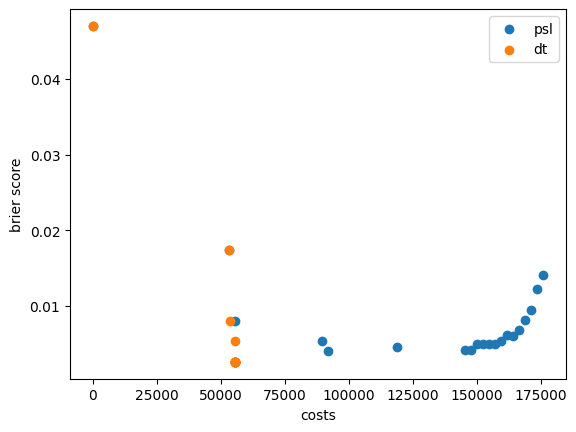

In [27]:
plt.scatter(costs_psl, briers_psl, label="psl")
plt.scatter(costs_dt, briers_dt, label="dt")

plt.xlabel("costs")
plt.ylabel("brier score")

plt.legend()
plt.show()

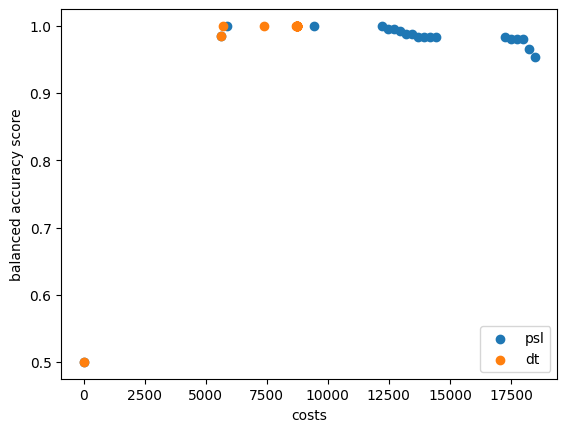

In [19]:
plt.scatter(costs_psl, baccs_psl, label="psl")
plt.scatter(costs_dt, baccs_dt, label="dt")

plt.xlabel("costs")
plt.ylabel("balanced accuracy score")

plt.legend(loc="lower right")
plt.show()

In [12]:
for k, pss in enumerate(psl):
    print(f"stage: {k} expected entropy {pss.score(X_train, y_train)}")

stage: 0 expected entropy 0.9992307463769627
stage: 1 expected entropy 0.08397183083434692
stage: 2 expected entropy 0.034413779594588294
stage: 3 expected entropy 0.019241910290754383
stage: 4 expected entropy 0.00795945822426556
stage: 5 expected entropy 0.0
stage: 6 expected entropy 0.0
stage: 7 expected entropy 0.0
stage: 8 expected entropy 0.0
stage: 9 expected entropy 0.0
stage: 10 expected entropy 0.0
stage: 11 expected entropy 0.0
stage: 12 expected entropy 0.0
stage: 13 expected entropy 0.0
stage: 14 expected entropy 0.0
stage: 15 expected entropy 0.018159225121442534
stage: 16 expected entropy 0.03215230707942421
stage: 17 expected entropy 0.055795741917999624
stage: 18 expected entropy 0.08477756256129648
stage: 19 expected entropy 0.11776585658359483
stage: 20 expected entropy 0.2657091789353269


[Text(0.5714285714285714, 0.9166666666666666, 'x[16] <= 0.006\nentropy = 0.302\nsamples = 4689\nvalue = [4437, 252]'),
 Text(0.42857142857142855, 0.75, 'entropy = 0.0\nsamples = 4322\nvalue = [4322, 0]'),
 Text(0.5, 0.8333333333333333, 'True  '),
 Text(0.7142857142857143, 0.75, 'x[2] <= 0.5\nentropy = 0.897\nsamples = 367\nvalue = [115.0, 252.0]'),
 Text(0.6428571428571428, 0.8333333333333333, '  False'),
 Text(0.5714285714285714, 0.5833333333333334, 'x[18] <= 0.15\nentropy = 0.584\nsamples = 293\nvalue = [41, 252]'),
 Text(0.42857142857142855, 0.4166666666666667, 'x[7] <= 0.5\nentropy = 0.426\nsamples = 276\nvalue = [24.0, 252.0]'),
 Text(0.2857142857142857, 0.25, 'x[18] <= 0.064\nentropy = 0.282\nsamples = 265\nvalue = [13, 252]'),
 Text(0.14285714285714285, 0.08333333333333333, 'entropy = 0.982\nsamples = 19\nvalue = [8, 11]'),
 Text(0.42857142857142855, 0.08333333333333333, 'entropy = 0.143\nsamples = 246\nvalue = [5, 241]'),
 Text(0.5714285714285714, 0.25, 'entropy = 0.0\nsamples 

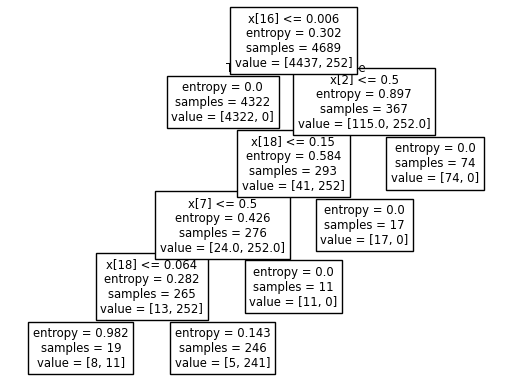

In [28]:
plot_tree(dt)


In [29]:
psl.inspect(k=10)

,Stage,Threshold,Feature Index,Score,T = -19,T = -17,T = -16,T = -15,T = -14,T = -13,T = -12,T = -11,T = -10,T = -9,T = -8,T = -7,T = -6,T = -5,T = -4,T = -3,T = -2,T = -1,T = 0,T = 1,T = 2,T = 3,T = 4,T = 5,T = 7
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.053743,NaN,NaN,NaN,NaN,NaN,NaN
1,1,>0.0060,16.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,0.686649,NaN,NaN,NaN
2,2,NaN,2.0,-3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.000000,NaN,NaN,0.860068,NaN,NaN,NaN
3,3,>0.1505,18.0,-3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.000000,NaN,NaN,0.913043,NaN,NaN,NaN
4,4,NaN,7.0,-3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.000000,NaN,NaN,0.950943,NaN,NaN,NaN
5,5,>0.0285,17.0,-2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.000000,0.333333,NaN,0.972656,NaN,NaN,NaN
6,6,>0.1175,19.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.970464,NaN,1.0,NaN
7,7,>0.0750,0.0,-2.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.970085,0.985043,1.000000,NaN,1.0,NaN
8,8,NaN,3.0,2.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.969697,0.984848,1.000000,1.0,1.0,1.0
9,9,NaN,6.0,-3.0,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.969697,0.984848,1.000000,1.0,1.0,1.0
